In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import math
import scipy as sc
from scipy.stats import norm
import statsmodels.genmod.generalized_linear_model as st
from matplotlib import pyplot as plt
import statsmodels.tsa.ar_model as armodel

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Exercice 1

#### 1.Bootstraping ma1 et ar1

In [2]:
def AR_sim(p,phis,epsilon):
    n = len(epsilon)
    if (len(phis)!=p) :
        print("le vecteur de paramètres n'a pas la bonne dimension ")
    X = np.zeros(n)
    for j in np.arange((p),(n)):
        X[j] = -np.dot(phis,X[(j-p):(j)]) +  epsilon[j]
    return(X[(p):(n)])

def MA_sim(q,psis,epsilon):
    n = len(epsilon)
    if (len(psis)!=q):
        print("le vecteur de paramètres n'a pas la bonne dimension")
    X = np.zeros(n)
    for j in np.arange((q+1),(n)):
        X[j] =  epsilon[j] + np.dot(psis,epsilon[(j-q):(j)])
    return(X[(q+1):(n)])

In [3]:
def sample(ar1,B):
    list_B=[]
    n=len(ar1)
    for k in range((B)):
        ind=npr.randint(0,n,n)
        sample=ar1[ind]
        list_B.append(sample)
    return(list_B)

In [4]:
n=200
epsilon = np.random.exponential(1,n)-1
phis=np.array([-0.6])
p=1
ar1 = AR_sim(p,phis,epsilon)

In [5]:
n=200
epsilon = np.random.exponential(1,n)-1
q=1
psis=np.array([0.5])
ma1=MA_sim(q,psis,epsilon)

In [6]:
B=100
list_ar1_boot = sample(ar1,B)
list_ma1_boot = sample(ma1,B)

#### 2.Représentation des séries

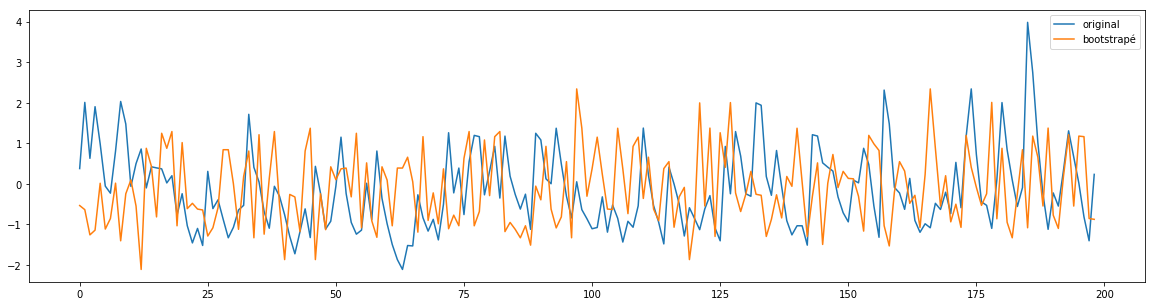

In [7]:
plt.figure(figsize=(20,5))
plt.plot(ar1)
plt.plot(list_ar1_boot[0])
plt.legend(['original','bootstrapé'])
plt.show()

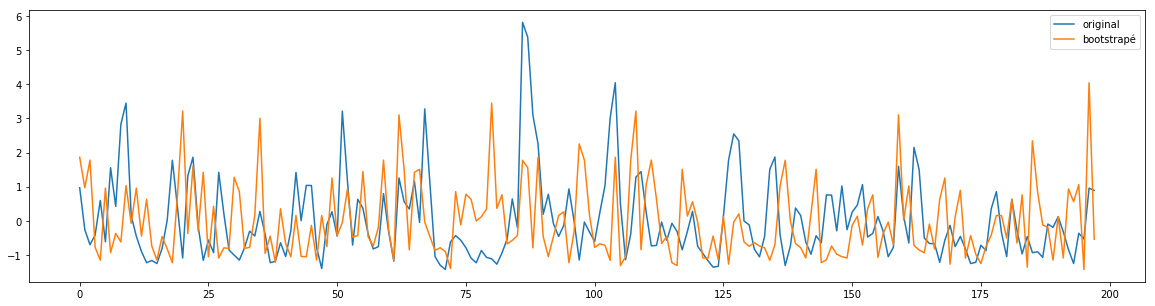

In [8]:
plt.figure(figsize=(20,5))
plt.plot(ma1)
plt.plot(list_ma1_boot[0])
plt.legend(['original','bootstrapé'])
plt.show()

#### 3. Limites de la méthode

Les échantillons bootstrapés n'ont pas la même distribution par rapport à l'échantillon initial. Le bootstraping classique ne suit donc pas le même processus aléatoire.

### Exercice 2

Génère un AR2 process

In [53]:
n=200
epsilon = np.random.exponential(1,n)-1
p=2
phis=npr.uniform(0,0.1,size=p)
ar1 = AR_sim(p,phis,epsilon)

#### 1. Estime $\hat{p}_{n}$ et les coef associés

In [55]:
ar1_model = armodel.AR(ar1)
p=ar1_model.select_order(maxlag=10,ic='aic')
print("Estimation de p_n: ",p)

fitted_ar1=ar1_model.fit(maxlag=p)
fitted_values_ar = fitted_ar1.fittedvalues

Estimation de p_n:  2


#### 2. Estime residus

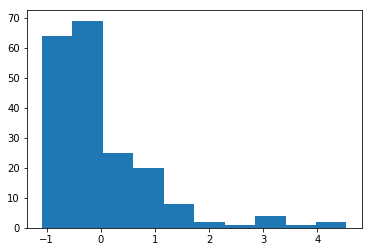

In [57]:
res_ar = fitted_ar1.resid
#recentre les résidus
res_ar = res_ar - 1/(n-p)*np.sum([res_ar[i] for i in np.arange(0,n-(p+2))])
plt.hist(res_ar)
plt.show()

On vérifie que les résidus sont bien centrés en 0

In [58]:
print(np.mean(res_ar))

9.063045098980869e-18


#### 3. Reconstruction de l'AR(p) process

In [59]:
B=100
phi=fitted_ar1.params[range(1,len(fitted_ar1.params))]  #on exclue l'intercept
Boots_list=[]
for b in range(B):
    #print(b)
    ind=npr.randint(p+1,len(ar1)-(p+1),1)
    Xboot=[]
    for t in range(p+1,len(ar1)-(p+1)):
        X=ar1[range(t-p,t)]
        Xboot.append(np.dot(phi,X.T)+fitted_ar1.params[0]+res_ar[ind])
    Boots_list.append(Xboot)

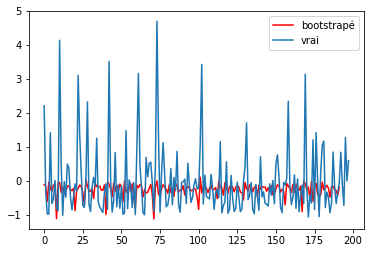

In [60]:
plt.plot(Boots_list[0],color='red')
plt.plot(ar1)
plt.legend(['bootstrapé','vrai'])
plt.show()

#### 2. Limites de la méthode

### Exercice 3

#### 1. et 2. Circulariser la série et définir l, N

In [236]:
#cercle de taille N*n
l=5
p=1
print("l=",l)
N=int(np.floor(n/l))
print("N=",N)
#circularise la série
X_circle = np.zeros(N*n)
t=0
for i in range(N*n):
    X_circle[i] = ma1[t]
    t=t+1
    if(t==len(ma1)):
        t=0

l= 5
N= 40


#### 3.Bootstraping

In [237]:
B=100
Boots_list_block=[]
for b in range(B):
    concat_X=[]
    for j in range(N):
        #(a) tire avec remise
        v_bk = ind=npr.randint(0,N,1)
        #(b) crée des blocs
        X_vb = X_circle[np.arange(v_bk,v_bk+l)]
        concat_X.append(X_vb)
    concat_X=np.array(concat_X).flatten()
    Boots_list_block.append(concat_X)

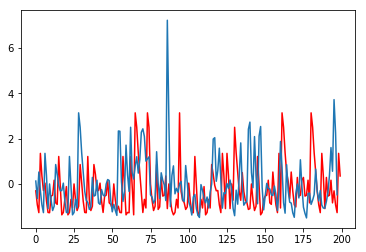

In [238]:
plt.plot(Boots_list_block[0],color='red')
plt.plot(ma1)
plt.show()

### Exercice 4

In [239]:
B=100
Boots_list_PR=[]
for b in range(B):
    concat_X=[]
    for j in range(N):
        #(a) tire avec remise
        v_bk = ind=npr.randint(0,N,1)
        #(b) crée des blocs
        l_geom = npr.geometric(1/l)
        X_vb = list(X_circle[np.arange(v_bk,v_bk+l_geom)])
        concat_X=concat_X+X_vb
    #concat_X=np.array(concat_X).flatten()
    Boots_list_PR.append(concat_X)

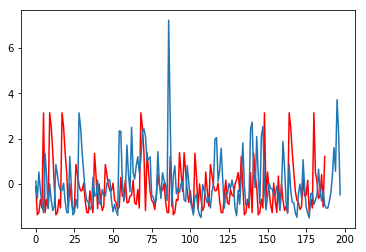

In [240]:
plt.plot(Boots_list_PR[0],color='red')
plt.plot(ma1)
plt.show()

### Exercice 5

In [241]:
import statsmodels.tsa.stattools as stat_ts

In [242]:
rho2_block_list=[]
rho2_PR_list=[]
for b in range(len(Boots_list_block)):
    rho2_block_list.append( stat_ts.acf(Boots_list_block[b],nlags=2)[2] )
    rho2_PR_list.append( stat_ts.acf(Boots_list_PR[b],nlags=2)[2] )

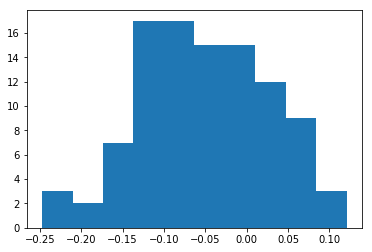

In [243]:
plt.hist(rho2_block_list)
plt.show()

In [244]:
def var_boot(rho):
    B=len(rho)
    sum1=np.mean(rho)
    return( (1/B*np.sum(rho-np.ones(B)*sum1))**2 )

In [246]:
print(var_boot(rho2_block_list))
print(var_boot(rho2_PR_list))

5.565937539279113e-36
7.888609052210118e-35
